In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)

In [2]:
# MNIST Dataset parameters.
num_features = 784 # data features (img shape: 28*28).

# Training parameters.
learning_rate = 0.01
training_steps = 2000
batch_size = 256
display_step = 1000

# Network Parameters
num_hidden_1 = 128 # 1st layer num features.
num_hidden_2 = 64 # 2nd layer num features 
num_latent = 32


img_rows = 28
img_cols = 28
img_chns = 1

# batch_size = 100
# latent_dim = 32
# intermediate_dim = 128
# epsilon_std = 1.0
# # epochs = 1000
# epochs = 100

# activation = 'elu'
# dropout = 0.0
# learning_rate = 0.001
# decay = 0.0
# num_iaf = 4

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_test = X_train.astype(np.float32), X_test.astype(np.float32)

X_train = np.round(X_train.reshape(X_train.shape[0], img_rows * img_cols) / 255.)
X_test = np.round(X_test.reshape(X_test.shape[0], img_rows * img_cols) / 255.)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


In [4]:
# (60000, 784) 的x_train切片，切成60000份，每个train_data都是 784的大小
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# repeat() 相当于一个dataset训练两遍，batch是一次取出256个image的数据，prefetch(1)是每次预存一个batch，shuffle指一个pool有多大
train_data = train_data.repeat().batch(batch_size).prefetch(1)

test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_data = test_data.repeat().batch(batch_size).prefetch(1)

In [5]:
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras import activations
from tensorflow.keras import regularizers
from tensorflow.keras import constraints


class MaskingDense(tf.keras.layers.Layer):
    """ Just copied code from keras Dense layer and added masking and a few other tricks:
        - Direct auto-regressive connections to output
        - Allows a second (non-autoregressive) input that is fully connected to first hidden
        - Either 1 output or 2 outputs (concatenated) that are separately
          auto-regressive wrt to the input
    """

    def __init__(self, units, out_units,
                 hidden_layers=1,
                 dropout_rate=0.0,
                 random_input_order=False,
                 activation='elu',
                 out_activation='sigmoid',
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 out_kernel_initializer='glorot_uniform',
                 out_bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(MaskingDense, self).__init__(**kwargs)

        self.input_sel = None
        self.random_input_order = random_input_order
        self.rate = min(1., max(0., dropout_rate))
        self.kernel_sels = []
        self.units = units
        self.out_units = out_units
        self.hidden_layers = hidden_layers
        self.activation = activations.get(activation)
        self.out_activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.out_kernel_initializer = initializers.get(out_kernel_initializer)
        self.out_bias_initializer = initializers.get(out_bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

    def dropout_wrapper(self, inputs, training):
        if 0. < self.rate < 1.:
            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape=None, seed=None)
            return K.in_train_phase(dropped_inputs, inputs,
                                    training=training)

        return inputs

    def build_layer_weights(self, input_dim, units, use_bias=True, is_output=False):
        kernel_initializer = (self.kernel_initializer if not is_output
                              else self.out_kernel_initializer)
        bias_initializer = (self.bias_initializer if not is_output
                            else self.out_bias_initializer)

        kernel = self.add_weight(shape=(input_dim, units),
                                 initializer=kernel_initializer,
                                 name='kernel',
                                 regularizer=self.kernel_regularizer,
                                 constraint=self.kernel_constraint)

        if use_bias:
            bias = self.add_weight(shape=(units,),
                                   initializer=bias_initializer,
                                   name='bias',
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        else:
            bias = None

        return kernel, bias

    def build_mask(self, shape, prev_sel, is_output):
        if is_output:
            if shape[-1] == len(self.input_sel):
                input_sel = self.input_sel
            else:
                input_sel = self.input_sel * 2
        else:
            # Disallow D-1 because it would violate auto-regressive property
            # Disallow unconnected units by sampling min from previous layer
            input_sel = [np.random.randint(np.min(prev_sel), shape[-1] - 2) for i in range(shape[-1])]

        def vals():
            in_len = len(self.input_sel)
            for x in range(shape[-2]):
                for y in range(shape[-1]):
                    if is_output:
                        yield 1 if prev_sel[x] < input_sel[y % in_len] else 0
                    else:
                        yield 1 if prev_sel[x] <= input_sel[y] else 0

        return K.constant(list(vals()), dtype='float32', shape=shape), input_sel

    def build(self, input_shape):
        if isinstance(input_shape, list):
            if len(input_shape) != 2:
                raise ValueError('Only list only supported for exactly two inputs')
            input_shape, other_input_shape = input_shape

            # Build weights for other (non-autoregressive) vector
            other_shape = (other_input_shape[-1], self.units)
            self.other_kernel, self.other_bias = self.build_layer_weights(*other_shape)

        assert len(input_shape) >= 2
        assert self.out_units == input_shape[-1] or self.out_units == 2 * input_shape[-1]

        self.kernels, self.biases = [], []
        self.kernel_masks, self.kernel_sels = [], []
        shape = (input_shape[-1], self.units)

        self.input_sel = np.arange(input_shape[-1])
        if self.random_input_order:
            np.random.shuffle(self.input_sel)
        prev_sel = self.input_sel
        for x in range(self.hidden_layers):
            # Hidden layer
            kernel, bias = self.build_layer_weights(*shape)
            self.kernels.append(kernel)
            self.biases.append(bias)

            # Hidden layer mask
            kernel_mask, kernel_sel = self.build_mask(shape, prev_sel, is_output=False)
            self.kernel_masks.append(kernel_mask)
            self.kernel_sels.append(kernel_sel)

            prev_sel = kernel_sel
            shape = (self.units, self.units)

        # Direct connection between input/output
        if self.hidden_layers > 0:
            direct_shape = (input_shape[-1], self.out_units)
            self.direct_kernel, _ = self.build_layer_weights(*direct_shape, use_bias=False,
                                                             is_output=True)
            self.direct_kernel_mask, self.direct_sel = self.build_mask(direct_shape, self.input_sel,
                                                                       is_output=True)

        # Output layer
        out_shape = (self.units, self.out_units)
        self.out_kernel, self.out_bias = self.build_layer_weights(*out_shape, is_output=True)
        self.out_kernel_mask, self.out_sel = self.build_mask(out_shape, prev_sel, is_output=True)

        self.built = True

    def call(self, inputs, training=None):
        other_input = None
        if isinstance(inputs, list):
            assert len(inputs) == 2
            assert self.hidden_layers > 0, "other input not supported if no hidden layers"
            assert hasattr(self, 'other_kernel')
            inputs, other_input = inputs

        output = inputs

        if other_input is not None:
            other = K.dot(other_input, self.other_kernel)
            other = K.bias_add(other, self.other_bias)
            other = self.activation(other)

        # Hidden layer + mask
        for i in range(self.hidden_layers):
            weight = self.kernels[i] * self.kernel_masks[i]
            output = K.dot(output, weight)

            # "other" input
            if i == 0 and other_input is not None:
                output = output + other

            output = K.bias_add(output, self.biases[i])
            output = self.activation(output)
#             output = self.dropout_wrapper(output, training)

        # out_act(bias + (V dot M_v)h(x) + (A dot M_a)x + (other dot M_other)other)
        output = K.dot(output, self.out_kernel * self.out_kernel_mask)

        # Direct connection
        if self.hidden_layers > 0:
            direct = K.dot(inputs, self.direct_kernel * self.direct_kernel_mask)
            output = output + direct

        output = K.bias_add(output, self.out_bias)
        output = self.out_activation(output)
#         output = self.dropout_wrapper(output, training)

        return output

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]
        return (input_shape[0], self.out_units)


$$
KL\Big(N(\mu,\sigma^2)\Big\Vert N(0,1)\Big)=\frac{1}{2}\Big(-\log \sigma^2+\mu^2+\sigma^2-1\Big)
$$

这里由于$\sigma$非负，所以是训练的 $\log\sigma $用z_std来代表的。

reconstruction loss是交叉熵

In [6]:
def vae_loss(x_reconstructed, x_true, z_mean, z_std):
    # Reconstruction loss
    encode_decode_loss = x_true * tf.math.log(1e-10 + x_reconstructed) \
                         + (1 - x_true) * tf.math.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    # KL Divergence loss
    kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)

In [7]:
def logpz(x, x_decoded_mean):
    return -K.sum(0.5 * np.log(2*math.pi) + 0.5 * z ** 2, axis=-1)

def logqz_x(x, x_decoded_mean):
    det = _z_log_sigma_0
    for z_sigma in _z_sigmas:
        det += K.log(z_sigma)
    
    return -K.sum(0.5 * np.log(2*math.pi) + 0.5 * e_0 ** 2 + det, axis=-1)

def logpx_z(x, x_decoded_mean):
    x = K.flatten(x)
    x_decoded_mean = K.flatten(x_decoded_mean)
    xent_loss = img_rows * img_cols * img_chns * tf.keras.metrics.binary_crossentropy(x, x_decoded_mean)
    return -xent_loss

def iaf_loss(x, x_decoded_mean):
    # ELBO: - [logp(x|z) + logp(z) - logq(z|x)] = -logp(x|z) - logp(z) + logq(z|x) 实际上他们的ELBO没有区别
#     return K.mean(-logpx_z(x, x_decoded_mean) - logpz(x, x_decoded_mean) + logqz_x(x, x_decoded_mean), axis=-1)
#     return K.mean(-logpx_z(x, x_decoded_mean), axis=-1)
    return -logpx_z(x, x_decoded_mean)

In [8]:
def make_iaf_layer(prev_z, enc_h, reverse=False):
    if reverse:
        prev_z = Lambda(lambda x: K.reverse(x, axes=-1))(prev_z)
    
    # 输入prev_z 和 h，得到 m 和 s
    iaf_in = [prev_z, enc_h] if enc_h is not None else prev_z
    m = MaskingDense(masking_dim, latent_dim, dropout_rate=0., hidden_layers=2,
                     kernel_regularizer=l2(0.001),
                     bias_regularizer=l2(0.001),
                     activation='sigmoid', out_activation=None)(iaf_in)
    s = MaskingDense(masking_dim, latent_dim, dropout_rate=0., hidden_layers=2,
                     kernel_regularizer=l2(0.001),
                     bias_regularizer=l2(0.001),
                     activation='sigmoid', out_activation=None)(iaf_in)
    sigma = tf.keras.activations.sigmoid(s)
    
    # 计算下一个z
#     next_z = prev_z * sigma + m * (1. - sigma)
#     return next_z, sigma
    # 为什么lambda这么重要？？？？没有居然还有错了
    return Lambda(combine_arnn)([prev_z, m, sigma]), sigma

In [9]:
latent_dim = 32
intermediate_dim = 128
num_iaf = 2

In [10]:
if tf.keras.backend.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)

In [11]:
def epsilon(args, batch_size=batch_size, latent_dim=latent_dim, epsilon_std=1.0):
    return K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)

def combine_z_0(args, batch_size=batch_size, latent_dim=latent_dim, epsilon_std=1.0):
    eps, z_mean, z_log_sigma = args
    return z_mean + tf.math.exp(z_log_sigma) * eps

def combine_arnn(args):
    # 聚合z ，sigma， mean，计算出下一个z
    z_t, mean, sigma = args
    return z_t * sigma + mean * (1. - sigma)

In [13]:
class IAF(tf.keras.Model):
    def __init__(self):
        super().__init__()
        masking_dim = 10 * latent_dim
        self.dense1 = Dense(units=intermediate_dim, activation=tf.nn.sigmoid)
        self.densez = Dense(units=latent_dim)
        self.denselog_sigma = Dense(units=latent_dim)
        self.denseh = Dense(latent_dim, activation='sigmoid')
        # 动态初始化
        self.maskdense_m = MaskingDense(masking_dim, latent_dim, dropout_rate=0., hidden_layers=2,
                             kernel_regularizer=l2(0.001),
                             bias_regularizer=l2(0.001),
                             activation='sigmoid', out_activation=None)
        self.maskdense_s = MaskingDense(masking_dim, latent_dim, dropout_rate=0., hidden_layers=2,
                             kernel_regularizer=l2(0.001),
                             bias_regularizer=l2(0.001),
                             activation='sigmoid', out_activation=None)
        self.act = tf.keras.activations.sigmoid
        self.densex = tf.keras.layers.Dense(units=img_rows * img_cols, activation=tf.nn.sigmoid)
        
    @tf.function
    def comput(self, inputs):
        x = self.dense1(inputs)

        # 初始的z_0
        _z_mean_0 = self.densez(x)
        _z_log_sigma_0 = self.denselog_sigma(x)
        e_0 = tf.keras.backend.random_normal(tf.shape(_z_log_sigma_0), dtype=tf.float32, mean=0., stddev=1.0)
        z_0 = _z_mean_0 + tf.math.exp(_z_log_sigma_0) * e_0

        _z_sigmas = []
        masking_dim = 10 * latent_dim
        h = self.denseh(x)
        z_t = z_0
        
        # todo 这里应该定义两次，而不是用循环来重复使用
        for i in range(num_iaf):
            reverse = (i > 0) # 依赖是反向的
            
            prev_z, enc_h = z_t, h
            if reverse:
                prev_z = Lambda(lambda x: K.reverse(x, axes=-1))(prev_z)
            iaf_in = [prev_z, enc_h] if enc_h is not None else prev_z
            m = self.maskdense_m(iaf_in)
            s = self.maskdense_s(iaf_in)
            sigma = self.act(s)
    
            z_t = prev_z * sigma + m * (1. - sigma)
            _z_sigma_t = sigma
    
            _z_sigmas.append(_z_sigma_t)
        z = z_t
        decode_x = self.decode(z)
        return e_0, _z_log_sigma_0, z, _z_sigmas, decode_x
    
    def decode(self, inputs):
        return self.densex(inputs)

In [14]:
# 传统方式Subclassing API模型
epochs = 2
training_steps = 1000
iaf = IAF()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
for step, (inputs, _) in enumerate(train_data.take(training_steps + 1)):
    with tf.GradientTape() as g:
        e_0, _z_log_sigma_0, z, _z_sigmas, decode_x = iaf.comput(inputs)
        logpz = -K.sum(0.5 * np.log(2*math.pi) + 0.5 * z ** 2, axis=-1)

        det = _z_log_sigma_0
        for z_sigma in _z_sigmas:
                det += K.log(z_sigma)
        logqz_x = -K.sum(0.5 * np.log(2*math.pi) + 0.5 * e_0 ** 2 + det, axis=-1)

        x = K.flatten(inputs)
        x_decoded_mean = K.flatten(decode_x)
        xent_loss = img_rows * img_cols * img_chns * tf.keras.metrics.binary_crossentropy(x, x_decoded_mean)
        # logpx_z = -xent_loss
        logpx_z = -tf.keras.metrics.binary_crossentropy(x, x_decoded_mean)

        loss = K.mean(-logpx_z - logpz + logqz_x, axis=-1)
        
        if step % display_step == 0:
            print("step: %i, loss: %f" % (step, loss))
            
    gradients = g.gradient(loss, iaf.variables)

    optimizer.apply_gradients(grads_and_vars=zip(gradients, iaf.variables))

step: 0, loss: 23.085592
step: 1000, loss: 0.395262


In [16]:
def draw_all_in_a_batch(latent, n=16):
    num_new_img = n * n

    canvas_recon = np.empty((28 * n, 28 * n))
    new_images = iaf.decode(latent)

    for i in range(n):
        for j in range(n):
            img = new_images[i*n+j].numpy().reshape([28, 28])
            
            # 两种方式都没有办法达到那种渐变效果，渐变效果是因为他的latent的生成受到了严格的控制，而不是像下面这样都是随机的
            
            canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = img
        
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_recon, origin="upper", cmap="gray")
    plt.show()

W0430 12:47:15.156496  8516 base_layer.py:1790] Layer dense_4 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



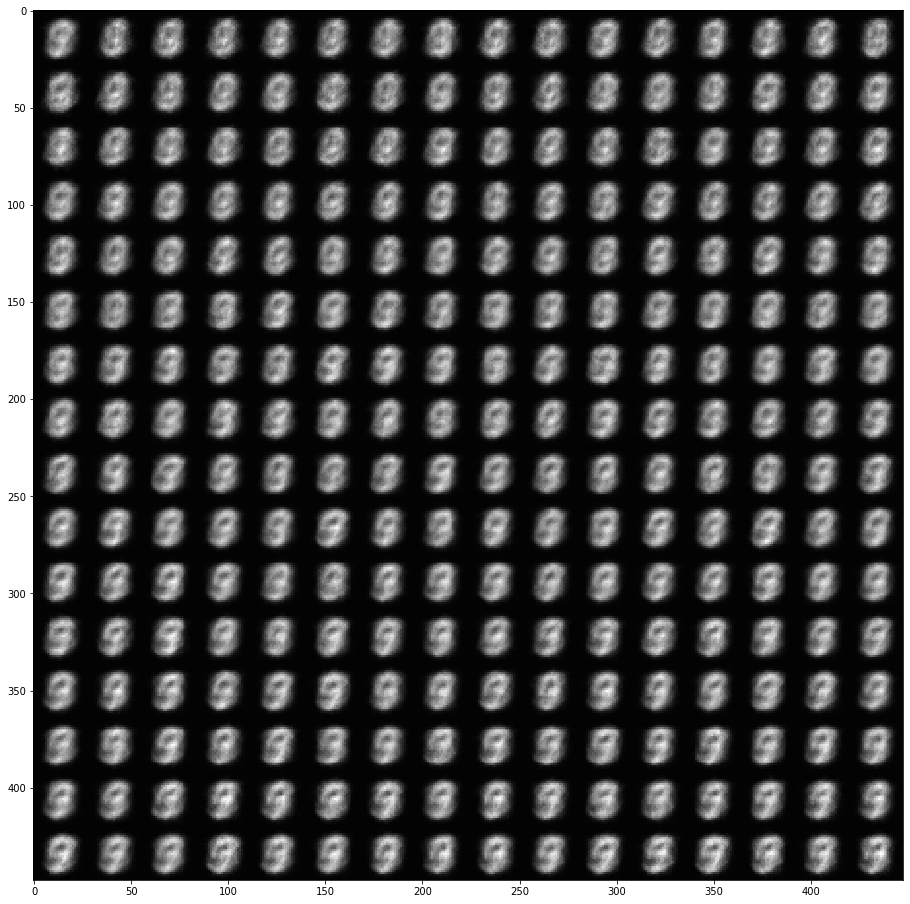

In [18]:
# 先生成255个从 -1 到 1 的递增序列，再按照这个序列作为均值，生成num_latent个latent，就生成了一个新的Z。
x_axis = np.linspace(-1, 1, 255)
ep = np.random.normal(0, 1, size=(1, num_latent))
for i in x_axis:
    ep = np.append(ep, np.random.normal(i, 1, size=(1, num_latent)), axis=0)
    
draw_all_in_a_batch(tf.convert_to_tensor(ep))

In [12]:
# Keras Sequential/Functional API
inputs = tf.keras.Input(shape=(img_rows * img_cols,), batch_size=batch_size)

x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.sigmoid)(x)

# 初始的z_0
_z_mean_0 = tf.keras.layers.Dense(units=latent_dim)(x)
_z_log_sigma_0 = tf.keras.layers.Dense(units=latent_dim)(x)
e_0 = tf.keras.backend.random_normal(tf.shape(_z_log_sigma_0), dtype=tf.float32, mean=0., stddev=1.0)
z_0 = _z_mean_0 + tf.math.exp(_z_log_sigma_0) * e_0
# e_0 = Lambda(epsilon)(x)
# z_0 = Lambda(combine_z_0)([e_0, _z_mean_0, _z_log_sigma_0])

# IAF 
_z_sigmas = []
masking_dim = 10 * latent_dim
h = tf.keras.layers.Dense(latent_dim, activation='sigmoid')(x)
z_t = z_0

for i in range(num_iaf):
    reverse = (i > 0) # 依赖是反向的
    # 原来的make_iaf_layer
    prev_z, enc_h = z_t, h
    if reverse:
        prev_z = Lambda(lambda x: K.reverse(x, axes=-1))(prev_z)
    iaf_in = [prev_z, enc_h] if enc_h is not None else prev_z
    m = MaskingDense(masking_dim, latent_dim, dropout_rate=0., hidden_layers=2,
                     kernel_regularizer=l2(0.001),
                     bias_regularizer=l2(0.001),
                     activation='sigmoid', out_activation=None)(iaf_in)
    s = MaskingDense(masking_dim, latent_dim, dropout_rate=0., hidden_layers=2,
                     kernel_regularizer=l2(0.001),
                     bias_regularizer=l2(0.001),
                     activation='sigmoid', out_activation=None)(iaf_in)
    sigma = tf.keras.activations.sigmoid(s)
    
    #     z_t = Lambda(combine_arnn)([prev_z, m, sigma])
    z_t = prev_z * sigma + m * (1. - sigma)
    _z_sigma_t = sigma
    # todo 是因为这个z_t在外部的函数中使用了吗？所以有泄露的风险？那如何储存他的值呢？是说他在外部参与了运算？那为什么sigma和m没有报错？
    # Inputs to eager execution function cannot be Keras symbolic tensors 
    # 未定义的，在过程中进行运算的z_t就是Keras symbolic tensors
    
#     z_t, _z_sigma_t = make_iaf_layer(z_t, h, reverse=reverse)
    # 记录sigma
    _z_sigmas.append(_z_sigma_t)
    # 原来的make_iaf_layer
    
# 既然报错是add 1 ，那么第一遍循环应该是没有问题的，问题应该在循环之外，即从这里开始。在iaf_loss里面，调用了
# z，这个z的使用应该就是关键了
z = z_t

decode_x = tf.keras.layers.Dense(units=img_rows * img_cols, activation=tf.nn.sigmoid)(z)

# 这种属于model有多个输出，所以他的损失函数要特别设计
logpz = -K.sum(0.5 * np.log(2*math.pi) + 0.5 * z ** 2, axis=-1)

det = _z_log_sigma_0
for z_sigma in _z_sigmas:
        det += K.log(z_sigma)
logqz_x = -K.sum(0.5 * np.log(2*math.pi) + 0.5 * e_0 ** 2 + det, axis=-1)

x = K.flatten(inputs)
x_decoded_mean = K.flatten(decode_x)
xent_loss = img_rows * img_cols * img_chns * tf.keras.metrics.binary_crossentropy(x, x_decoded_mean)
# logpx_z = -xent_loss
logpx_z = -tf.keras.metrics.binary_crossentropy(x, x_decoded_mean)

vae_loss = K.mean(-logpx_z - logpz + logqz_x, axis=-1)
test_loss = tf.fill([256, 10], vae_loss) # 为了形状一致 

In [16]:
class iaf_loss_class(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        print("y_pred is:", y_pred)
        return tf.reduce_mean(y_pred)

iaf = tf.keras.Model(inputs=inputs, outputs=test_loss)
iaf_loss = iaf_loss_class()

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
iaf.compile(optimizer=optimizer, loss=iaf_loss)
# iaf.summary()

y_pred shape Tensor("Fill:0", shape=(256, 10), dtype=float32)


In [15]:
y_true = tf.zeros([60000, 10])
epochs = 2
start = time.time()
# train和label的第一维要匹配
history = iaf.fit(
    X_train, y_true,
    batch_size=batch_size,
    epochs=epochs,
#     validation_data=(X_test, X_test),
    verbose=0
)

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

y_pred shape Tensor("model/tf_op_layer_Fill/Fill:0", shape=(256, 10), dtype=float32)
y_pred shape Tensor("model/tf_op_layer_Fill/Fill:0", shape=(256, 10), dtype=float32)


InvalidArgumentError:  Incompatible shapes: [200704] vs. [75264]
	 [[node Mul_154 (defined at <ipython-input-15-6b7b56b97814>:10) ]] [Op:__inference_distributed_function_5124]

Function call stack:
distributed_function


In [ ]:
import pandas as pd
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df.plot(figsize=(8, 6))

In [ ]:
import matplotlib.pyplot as plt
n = 10
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

for j in range(n):
    for i in range(n):
        z_sample = np.random.normal(size=latent_dim).reshape(1, latent_dim)
        x_decoded = generator.predict(z_sample, batch_size=1)
        digit = x_decoded.reshape(digit_size, digit_size, img_chns)
        
        d_x = i * digit_size
        d_y = j * digit_size
        figure[d_x:d_x + digit_size, d_y:d_y + digit_size] = digit[:, :, 0]
        
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()